# Fine-tuning BERT to generate word embeddings

In [ ]:
import os

# Create the directory if it doesn't exist:
scratch_cache = "/ocean/projects/mth250011p/smazioud/huggingface_cache"
os.makedirs(scratch_cache, exist_ok=True)

# Force HuggingFace + PyTorch to store EVERYTHING there
os.environ['HF_HOME'] = scratch_cache
os.environ['TRANSFORMERS_CACHE'] = scratch_cache
os.environ['HF_DATASETS_CACHE'] = scratch_cache
os.environ['HF_MODULES_CACHE'] = scratch_cache
os.environ['HF_METRICS_CACHE'] = scratch_cache
os.environ['TORCH_HOME'] = scratch_cache

from huggingface_hub import login
login() # add your token here

print("HF cache directory:", scratch_cache)

HF cache directory: /ocean/projects/mth250011p/smazioud/huggingface_cache


In [4]:
import os
import sys
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import h5py   

import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertForMaskedLM, BertModel
from datasets import Dataset
from fine_tune_bert import mask_tokens, train_bert, apply_lora_to_bert
from data_cleaning import clean_data

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


/jet/home/smazioud/.conda/envs/env_215a/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device: cpu


In [5]:
repo_root = "/jet/home/smazioud/stat215a_final"
sys.path.append(repo_root)

raw_path = "/ocean/projects/mth250011p/shared/215a/final_project/data/raw_text.pkl"

with open(raw_path, "rb") as f:
    raw = pickle.load(f)

story_texts, story_ids = clean_data(raw)
print(f"\nNumber of stories: {len(story_texts)}")
print(f"Example story ID: {story_ids[0]}")
print(f"Example text (first 200 chars):\n{story_texts[0][:200]}\n")




Number of stories: 109
Example story ID: sweetaspie
Example text (first 200 chars):
['i', 'embarked', 'on', 'a', 'journey', 'toward', 'the', 'sea', 'of', 'matrimony', 'at', 'the', 'perilous', 'age', 'of', 'forty', 'one', 'yeah', "you'd", 'think', 'forty', 'one', 'a', 'trip', 'to', 'marriage', 'would', 'be', 'pretty', 'smooth', 'but', 'nobody', 'had', 'told', 'my', 'family', 'my', 'sister', 'called', 'me', 'up', 'and', 'she', 'said', 'you', 'have', 'to', 'order', 'engraved', 'invitations', 'i', 'said', 'i', "don't", 'think', 'so', "we're", 'having', 'a', 'potluck', 'she', 'called', 'again', 'people', 'are', 'asking', 'me', 'what', 'to', 'get', 'you', 'for', 'a', 'wedding', 'present', 'you', 'have', 'to', 'register', 'at', 'stores', 'i', 'said', 'i', "don't", 'think', 'so', "we're", 'combining', 'two', 'apartments', "we've", 'got', 'so', 'many', 'duplicates', "we're", 'trying', 'to', 'figure', 'out', 'what', 'to', 'give', 'away', 'but', 'they', 'want', 'to', 'give', 'you', 'presents', '

### Load tokenizer

In [5]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
print(f"Tokenizer loaded: {model_name}")

/jet/home/smazioud/.conda/envs/env_215a/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizer loaded: bert-base-uncased


### Tokenize dataset

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch

max_seq_len = 128  # fixed window length for BERT

# 3) Tokenize and chunk stories
story_chunks = []

for text in story_texts:
    token_ids = tokenizer(
        text,
        add_special_tokens=False,
        return_attention_mask=False,
        return_tensors=None,
        is_split_into_words=True
    )["input_ids"]

    story_input_ids = []
    story_attn = []

    for i in range(0, len(token_ids), max_seq_len):
        chunk = token_ids[i:i + max_seq_len]

        padded = tokenizer.pad(
                                {"input_ids": [chunk]},  # batch of size 1
                                padding="max_length",
                                max_length=max_seq_len,
                                return_attention_mask=True,
                                return_tensors="pt"
                            )

        story_input_ids.append(padded["input_ids"][0])
        story_attn.append(padded["attention_mask"][0])

    story_chunks.append((
        torch.stack(story_input_ids),
        torch.stack(story_attn)
    ))


# # 4) Stack into tensors
# input_ids = torch.stack(all_input_ids)         # (num_chunks, max_seq_len)
# attention_mask = torch.stack(all_attention_masks)

# print("Number of chunks:", input_ids.shape[0])
# print("Sequence length:", input_ids.shape[1])


Token indices sequence length is longer than the specified maximum sequence length for this model (810 > 512). Running this sequence through the model will result in indexing errors
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [6]:
class TextDataset(Dataset):
    def __init__(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        assert input_ids.shape == attention_mask.shape
        self.input_ids = input_ids
        self.attention_mask = attention_mask

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
        }

def flatten_story_chunks(stories):
    X = []
    A = []
    for ids, attn in stories:
        X.append(ids)
        A.append(attn)
    return torch.vstack(X), torch.vstack(A)



# Simple train/val split
val_frac = 0.2
n_stories = len(story_chunks)
n_val_stories = max(1, int(val_frac * n_stories))

train_stories = story_chunks[:-n_val_stories]
val_stories   = story_chunks[-n_val_stories:]

train_stories = story_chunks[:-n_val_stories]
val_stories   = story_chunks[-n_val_stories:]

train_ids, train_mask = flatten_story_chunks(train_stories)
val_ids,   val_mask   = flatten_story_chunks(val_stories)

train_dataset = TextDataset(train_ids, train_mask)
val_dataset   = TextDataset(val_ids, val_mask)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Train batches: 93, Val batches: 21


## Fine-tune

In [7]:
# Load BERT, apply LORA

from transformers import BertForMaskedLM

base_model = BertForMaskedLM.from_pretrained(model_name)
base_model = base_model.to(DEVICE)

print(f"Base model parameters: {sum(p.numel() for p in base_model.parameters()):,}")

# Wrap with LoRA adapters
lora_model = apply_lora_to_bert(base_model, r=8, alpha=16, dropout=0.1)
lora_model = lora_model.to(DEVICE)

print(f"LoRA-wrapped model is on device: {DEVICE}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Base model parameters: 109,514,298
trainable params: 1,339,392 || all params: 110,853,690 || trainable%: 1.208252066304694
LoRA-wrapped model is on device: cuda


In [8]:
epochs = 5
lr = 5e-5

trained_model = train_bert(
    model=lora_model,
    train_loader=train_loader,
    tokenizer=tokenizer,
    val_loader=val_loader,
    epochs=epochs,
    lr=lr,
    device=DEVICE,
)

output_dir = Path(repo_root) / "saved_models" / "bert_lora_finetuned"
output_dir.mkdir(parents=True, exist_ok=True)

trained_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Fine-tuned LoRA model saved to: {output_dir}")

Epoch 1/5: 100%|██████████| 93/93 [00:11<00:00,  7.96it/s, loss=2.67]


Epoch 1 train loss: 3.1548
Epoch 1 val loss: 2.7045


Epoch 2/5: 100%|██████████| 93/93 [00:11<00:00,  8.30it/s, loss=2.6] 


Epoch 2 train loss: 2.7843
Epoch 2 val loss: 2.5383


Epoch 3/5: 100%|██████████| 93/93 [00:11<00:00,  8.31it/s, loss=2.54]


Epoch 3 train loss: 2.7001
Epoch 3 val loss: 2.5105


Epoch 4/5: 100%|██████████| 93/93 [00:11<00:00,  8.30it/s, loss=2.57]


Epoch 4 train loss: 2.6928
Epoch 4 val loss: 2.5187


Epoch 5/5: 100%|██████████| 93/93 [00:11<00:00,  8.27it/s, loss=2.58]


Epoch 5 train loss: 2.6514
Epoch 5 val loss: 2.5671
Training complete.
Fine-tuned LoRA model saved to: /jet/home/smazioud/stat215a_final/saved_models/bert_lora_finetuned


/jet/home/smazioud/.conda/envs/env_215a/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Embeddings

In [9]:
from transformers import BertModel

output_dir = Path(repo_root) / "saved_models" / "bert_lora_finetuned"
finetuned_bert = BertModel.from_pretrained(output_dir, output_hidden_states=True)
finetuned_bert = finetuned_bert.to(DEVICE)
finetuned_bert.eval()

print("Loaded finetuned encoder for embeddings.")

Loading adapter weights from /jet/home/smazioud/stat215a_final/saved_models/bert_lora_finetuned led to unexpected keys not found in the model:  ['bert.encoder.layer.0.attention.output.dense.lora_A.default.weight', 'bert.encoder.layer.0.attention.output.dense.lora_B.default.weight', 'bert.encoder.layer.0.attention.self.key.lora_A.default.weight', 'bert.encoder.layer.0.attention.self.key.lora_B.default.weight', 'bert.encoder.layer.0.attention.self.query.lora_A.default.weight', 'bert.encoder.layer.0.attention.self.query.lora_B.default.weight', 'bert.encoder.layer.0.attention.self.value.lora_A.default.weight', 'bert.encoder.layer.0.attention.self.value.lora_B.default.weight', 'bert.encoder.layer.0.intermediate.dense.lora_A.default.weight', 'bert.encoder.layer.0.intermediate.dense.lora_B.default.weight', 'bert.encoder.layer.0.output.dense.lora_A.default.weight', 'bert.encoder.layer.0.output.dense.lora_B.default.weight', 'bert.encoder.layer.1.attention.output.dense.lora_A.default.weight', 'b

Loaded finetuned encoder for embeddings.


In [10]:
def get_bert_word_embeddings_for_words(
    words,
    tokenizer,
    model: BertModel,
    device=DEVICE,
    chunk_size: int = 256,
):
    """
    Compute word-level embeddings for a list of words using BERT.

    - Tokenize with is_split_into_words=True
    - Average subword token embeddings per word
    """
    model.eval()
    hidden_dim = model.config.hidden_size
    T = len(words)
    embs = np.zeros((T, hidden_dim), dtype=np.float32)

    start = 0
    with torch.no_grad():
        while start < T:
            end = min(start + chunk_size, T)
            chunk_words = words[start:end]

            enc = tokenizer(
                chunk_words,
                is_split_into_words=True,
                return_tensors="pt",
                padding=True,
                truncation=True,
            ).to(device)

            outputs = model(**enc)
            last_hidden = outputs.last_hidden_state.cpu()  # (1, L, H)

            # Map tokens back to original word indices
            word_ids = enc.word_ids(batch_index=0)
            word_to_vecs = {}

            for tok_idx, w_id in enumerate(word_ids):
                if w_id is None:
                    continue
                word_to_vecs.setdefault(w_id, []).append(last_hidden[0, tok_idx].numpy())

            # Average subword embeddings per word
            for local_w_id, vecs in word_to_vecs.items():
                global_w_id = start + local_w_id
                if global_w_id < T:
                    embs[global_w_id] = np.mean(vecs, axis=0)

            start = end

    return embs


In [11]:
bert_embeddings = {}  # story_id -> dict

output_dir = Path(repo_root) / "embeddings" / "bert_lora_finetuned"

for story_id, ds in raw.items():
    words = ds.data               # list[str]
    word_times = ds.data_times    # np.array, shape (T,)
    tr_times = ds.tr_times        # np.array, shape (n_TR,)

    print(f"Processing story: {story_id}, #words = {len(words)}")

    embs = get_bert_word_embeddings_for_words(
        words=words,
        tokenizer=tokenizer,
        model=finetuned_bert,
        device=DEVICE,
        chunk_size=256
    )  # shape (T, 768)

    print("  embeddings shape:", embs.shape)

    bert_embeddings[story_id] = {
        "words": words,
        "word_times": word_times,
        "tr_times": tr_times,
        "embeddings": embs,
    }

out_path = output_dir / "bert_lora_finetuned_word_embeddings.pkl"

with open(out_path, "wb") as f:
    pickle.dump(bert_embeddings, f)

Processing story: sweetaspie, #words = 697
  embeddings shape: (697, 768)
Processing story: thatthingonmyarm, #words = 2073
  embeddings shape: (2073, 768)
Processing story: tildeath, #words = 2297
  embeddings shape: (2297, 768)
Processing story: indianapolis, #words = 1554
  embeddings shape: (1554, 768)
Processing story: lawsthatchokecreativity, #words = 2084
  embeddings shape: (2084, 768)
Processing story: golfclubbing, #words = 1211
  embeddings shape: (1211, 768)
Processing story: jugglingandjesus, #words = 887
  embeddings shape: (887, 768)
Processing story: shoppinginchina, #words = 1731
  embeddings shape: (1731, 768)
Processing story: cocoonoflove, #words = 1984
  embeddings shape: (1984, 768)
Processing story: hangtime, #words = 1927
  embeddings shape: (1927, 768)
Processing story: beneaththemushroomcloud, #words = 1916
  embeddings shape: (1916, 768)
Processing story: dialogue4, #words = 1692
  embeddings shape: (1692, 768)
Processing story: thepostmanalwayscalls, #words 

## Visualizations

In [6]:
# check embeddings
output_dir = Path(repo_root) / "embeddings" / "bert_lora_finetuned"
out_path = output_dir / "bert_lora_finetuned_word_embeddings.pkl"
with open(out_path, "rb") as f:
    bert_emb = pickle.load(f)

print(type(bert_emb))
print(list(bert_emb.keys())[:5])
story_ids = list(bert_emb.keys())
second_id = story_ids[0]
second_id
item = bert_emb[second_id]

words = item["words"]              # list[str]
word_times = item["word_times"]    # numpy array, shape (T,)
embeddings = item["embeddings"]    # numpy array, shape (T, 768)

for i in range(5):
    print(f"{i:02d}  word = {words[i]!r}")
    print("embedding[:10] =", embeddings[i][:10])
    print()

<class 'dict'>
['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity']
00  word = ''
embedding[:10] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

01  word = 'i'
embedding[:10] = [ 0.18079548  0.14120214  0.22185925  0.33665928 -0.04094402  0.44426098
  0.06858034  0.5480445   0.3261385  -0.2745779 ]

02  word = 'embarked'
embedding[:10] = [-0.4355442   0.06102942  0.72449094 -0.12015888  0.57823557  0.4386239
  1.2360512   0.8551977   0.1705613  -0.3479677 ]

03  word = 'on'
embedding[:10] = [-0.9795116  -0.15706405  0.0756693   0.00270494  0.32887977  0.53881806
  0.12328833  1.2521068  -0.22967172 -0.18948457]

04  word = 'a'
embedding[:10] = [-0.526109   -0.12096308  0.243123    0.05260051  0.3603323   0.43253767
  0.726522    0.66895074 -0.2466641  -0.09764611]



### PCA

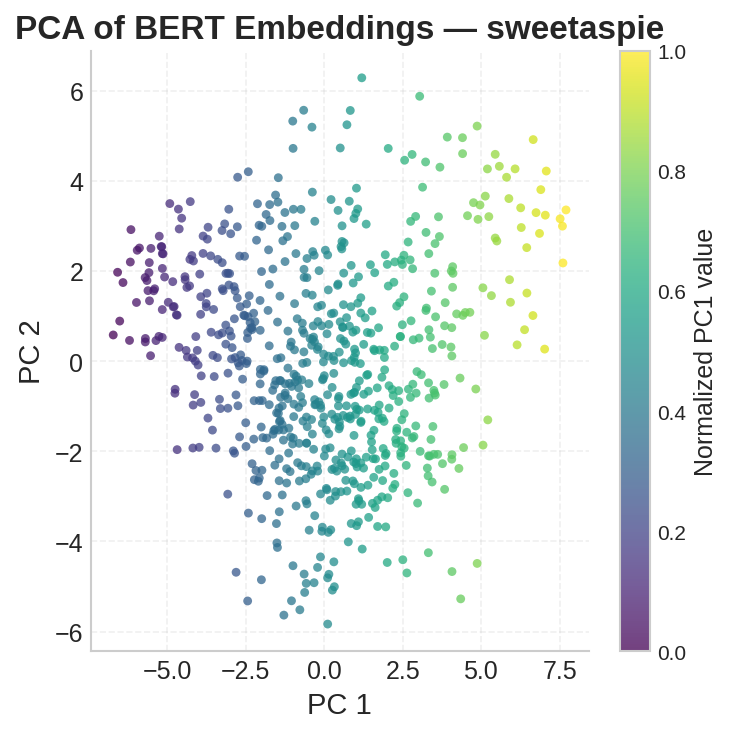

In [9]:
# PCA and visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2 = pca.fit_transform(embeddings)

norm = (X2[:,0] - X2[:,0].min()) / (X2[:,0].max() - X2[:,0].min())

plt.figure(figsize=(5,5), dpi=150)
plt.style.use("seaborn-v0_8-whitegrid")

# Scatter plot with transparency + colormap
plt.scatter(
    X2[:,0], X2[:,1],
    c=norm, cmap="viridis",     
    s=18,                      
    alpha=0.75,                
    edgecolor="none"
)

plt.title(f"PCA of BERT Embeddings — {second_id}", fontsize=16, fontweight="bold")
plt.xlabel("PC 1", fontsize=14)
plt.ylabel("PC 2", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle="--", alpha=0.3)

for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

cbar = plt.colorbar()
cbar.set_label("Normalized PC1 value", fontsize=12)

plt.tight_layout()
plt.show()

### t-SNE

[INFO] unique words = 277
[INFO] labeling top 70 unique words
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 277 samples in 0.000s...
[t-SNE] Computed neighbors for 277 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 277 / 277
[t-SNE] Mean sigma: 0.378508
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.053909
[t-SNE] KL divergence after 1000 iterations: 0.972066


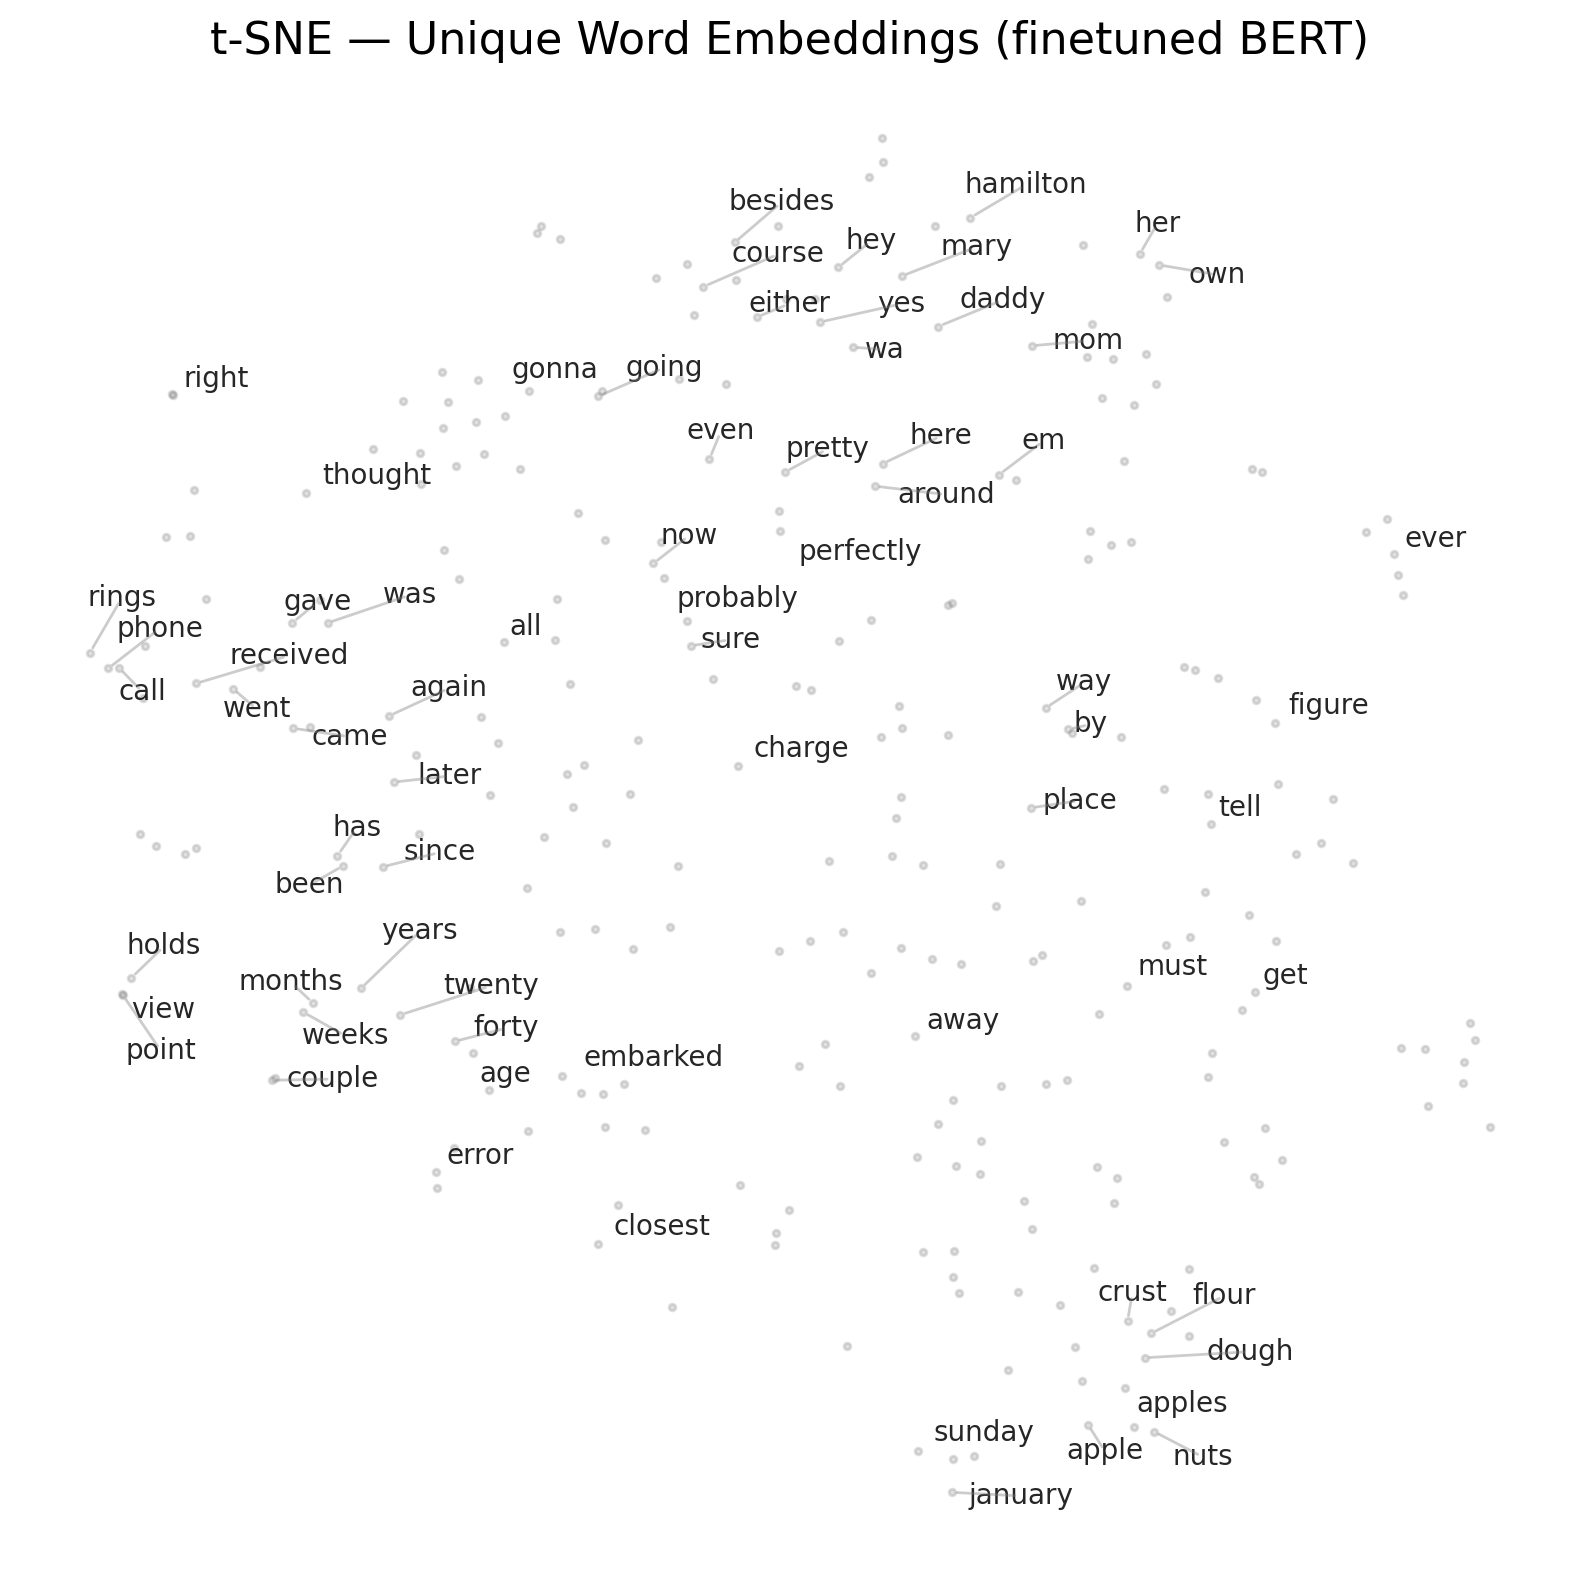

In [ ]:
# tSNE and visualization

from adjustText import adjust_text
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# group embeddings by word
word2vecs = defaultdict(list)
for w, v in zip(words, embeddings):
    w_clean = w.strip()
    if w_clean:
        word2vecs[w_clean].append(v)

# average pooling to get one embedding per unique word
unique_words = []
unique_embs = []

for w, vecs in word2vecs.items():
    unique_words.append(w)
    unique_embs.append(np.mean(vecs, axis=0))

unique_embs = np.array(unique_embs)
print(f"[INFO] unique words = {len(unique_words)}")


# Select top words to label
scores = np.linalg.norm(unique_embs, axis=1)
top_k = 70
top_idx = np.argsort(scores)[-top_k:]
print(f"[INFO] labeling top {top_k} unique words")


# PCA reduce to 50 dims (safer for t-SNE)
pca = PCA(n_components=min(50, unique_embs.shape[1], unique_embs.shape[0]-1))
X50 = pca.fit_transform(unique_embs)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    metric="cosine",
    random_state=42,
    verbose=1
)
X2 = tsne.fit_transform(X50)


# Plot + labels
plt.figure(figsize=(8,8), dpi=200)
plt.scatter(X2[:,0], X2[:,1], s=6, alpha=0.25, color="gray")

texts = []
for i in top_idx:
    t = plt.text(
        X2[i,0], X2[i,1],
        unique_words[i],
        fontsize=10,
        alpha=0.85
    )
    texts.append(t)


# auto adjust text to reduce overlaps
adjust_text(
    texts,
    arrowprops=dict(
        arrowstyle="-",
        color="gray",
        alpha=0.4
    ),
    expand_text=(1.1, 1.2),
    force_points=0.15,
    force_text=0.3
)

plt.title("t-SNE — Unique Word Embeddings (finetuned BERT)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.savefig("../figures/bert_finetuned_tsne_unique.pdf", bbox_inches="tight", dpi=300)
plt.show()

## Pre-processing

In [16]:
from preprocessing import downsample_word_vectors, make_delayed

BASE_DIR = Path("/ocean/projects/mth250011p/shared/215a/final_project")
TEXT_PATH = BASE_DIR / "data" / "raw_text.pkl"

BOLD_BASE = BASE_DIR / "data"
SUBJECT_DIRS = {
    2: BOLD_BASE / "subject2",
    3: BOLD_BASE / "subject3",
}
BERT_EMB_PATH = Path(repo_root) / "embeddings" / "bert_lora_finetuned" / "bert_lora_finetuned_word_embeddings.pkl"

# DataSequence (wordseqs)
with open(TEXT_PATH, "rb") as f:
    wordseqs = pickle.load(f)   # dict: story_id -> DataSequence

print("wordseqs stories:", list(wordseqs.keys())[:5])

# BERT embedding
with open(BERT_EMB_PATH, "rb") as f:
    bert_emb = pickle.load(f)   # dict: story_id -> {..., "embeddings": (T,768)}

print("bert_emb stories:", list(bert_emb.keys())[:5])

# check story id
stories = sorted(set(wordseqs.keys()) & set(bert_emb.keys()))
print("num stories:", len(stories))
stories[:5]

wordseqs stories: ['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity']
bert_emb stories: ['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity']
num stories: 109


['adollshouse',
 'adventuresinsayingyes',
 'afatherscover',
 'afearstrippedbare',
 'againstthewind']

### Downsample

In [ ]:
# downsample_word_vectors
word_vectors = {}
for sid in stories:
    embs = bert_emb[sid]["embeddings"]   # (num_words, 768)
    word_vectors[sid] = embs.astype("float32")

downsampled_semanticseqs = downsample_word_vectors(
    stories=stories,
    word_vectors=word_vectors,
    wordseqs=wordseqs
)

### Trim and delay

In [18]:
OUT_DIR = Path("/ocean/projects/mth250011p/smazioud/preprocessing")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def preprocess_subject_streaming(subject_id, delays=None):
    subj_dir = SUBJECT_DIRS[subject_id]
    assert subj_dir.is_dir(), f"{subj_dir} does not exist"

    missing_stories = []

    for sid in stories:
        ds = wordseqs[sid]
        tr_times = ds.tr_times
        stim_tr  = downsampled_semanticseqs[sid]

        assert stim_tr.shape[0] == len(tr_times)

        bold_path = subj_dir / f"{sid}.npy"
        if not bold_path.is_file():
            print(f"[WARN] Subject {subject_id}: missing BOLD for story '{sid}', skipping.")
            missing_stories.append(sid)
            continue

        bold = np.load(bold_path)

        n_stim = stim_tr.shape[0]
        n_bold = bold.shape[0]

        if n_stim < n_bold:
            print(f"[WARN] {sid}: stim shorter than bold, skipping.")
            missing_stories.append(sid)
            continue

        trim_start = 10
        trim_end   = 5

        # check length
        if n_stim - trim_start - trim_end < n_bold:
            print(f"[WARN] {sid}: stim too short after fixed trimming, skipping.")
            missing_stories.append(sid)
            continue

        stim_trim = stim_tr[trim_start : n_stim - trim_end]

        # after trimming, must match bold length
        if stim_trim.shape[0] != n_bold:
            print(
                f"[WARN] {sid}: mismatch after fixed trim "
                f"(stim={stim_trim.shape[0]}, bold={n_bold}), skipping."
            )
            missing_stories.append(sid)
            continue

        if stim_trim.shape[0] != n_bold:
            print(f"[WARN] {sid}: mismatch after trim, skipping.")
            missing_stories.append(sid)
            continue

        # delay
        if delays is None:
            raise ValueError("delays must be provided if only X_delayed is saved.")

        X_delayed = make_delayed(stim_trim, delays=delays)
        X_delayed = X_delayed.astype("float32")

        bold = bold.astype("float32")

        result = {
            "X_delayed": X_delayed,   # (N, 768 * len(delays))
            "bold": bold,             # (N, n_vox)
        }

        out_file = OUT_DIR / f"subject{subject_id}_{sid}_Xdelayed.pkl"
        with open(out_file, "wb") as f:
            pickle.dump(result, f)

        print(
            f"[SAVE] Subject {subject_id}, story {sid}: "
            f"X_delayed {X_delayed.shape}, bold {bold.shape}, saved"
        )

        del bold, stim_trim, X_delayed, result

    if missing_stories:
        print(f"\n[INFO] Subject {subject_id} skipped stories:")
        for s in missing_stories:
            print("  -", s)
    else:
        print(f"\n[INFO] Subject {subject_id}: all stories processed.")

In [19]:
delays = [1,2,3,4]
preprocess_subject_streaming(2, delays=delays)
preprocess_subject_streaming(3, delays=delays)

[SAVE] Subject 2, story adollshouse: X_delayed (241, 3072), bold (241, 94251), saved
[SAVE] Subject 2, story adventuresinsayingyes: X_delayed (391, 3072), bold (391, 94251), saved
[SAVE] Subject 2, story afatherscover: X_delayed (312, 3072), bold (312, 94251), saved
[SAVE] Subject 2, story afearstrippedbare: X_delayed (427, 3072), bold (427, 94251), saved
[SAVE] Subject 2, story againstthewind: X_delayed (170, 3072), bold (170, 94251), saved
[SAVE] Subject 2, story alternateithicatom: X_delayed (343, 3072), bold (343, 94251), saved
[SAVE] Subject 2, story avatar: X_delayed (367, 3072), bold (367, 94251), saved
[SAVE] Subject 2, story backsideofthestorm: X_delayed (345, 3072), bold (345, 94251), saved
[SAVE] Subject 2, story becomingindian: X_delayed (388, 3072), bold (388, 94251), saved
[SAVE] Subject 2, story beneaththemushroomcloud: X_delayed (342, 3072), bold (342, 94251), saved
[SAVE] Subject 2, story birthofanation: X_delayed (264, 3072), bold (264, 94251), saved
[SAVE] Subject 2,